# FLORIS Wake Effect Simulation for Hill of Towie Wind Farm

## Objective
Use FLORIS (FLOw Redirection and Induction in Steady State) to:
- Simulate wake effects with actual turbine positions
- Quantify power losses from wake interactions
- Create physics-based features for ML models
- Validate the importance of using all 21 turbines

In [1]:
import subprocess
import sys
import floris
print(f"FLORIS version: {floris.__version__}")

FLORIS version: 4.4.2


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
import math
from floris import FlorisModel
from floris.flow_visualization import visualize_cut_plane
import matplotlib.patches as patches

warnings.filterwarnings('ignore')

# Setup
PROJECT_ROOT = Path('../').resolve()
DATA_DIR = PROJECT_ROOT / 'data'
TRAIN_PATH = DATA_DIR / 'train' / 'training_dataset.parquet'
METADATA_PATH = DATA_DIR / 'turbine_metadata.csv'

# Load data
train_df = pd.read_parquet(TRAIN_PATH)
metadata_df = pd.read_csv(METADATA_PATH)

# Extract turbine IDs
metadata_df['turbine_id'] = metadata_df['Turbine Name'].str.extract(r'T(\d+)').astype(int)

print(f"Loaded {len(train_df)} training records")
print(f"Loaded metadata for {len(metadata_df)} turbines")

Loaded 210384 training records
Loaded metadata for 21 turbines


## 1. Prepare Turbine Layout for FLORIS

In [3]:
def latlon_to_meters(lat1, lon1, lat2, lon2):
    """Convert lat/lon to meters using Haversine formula"""
    R = 6371000  # Earth radius in meters
    
    lat1_rad = math.radians(lat1)
    lat2_rad = math.radians(lat2)
    delta_lat = math.radians(lat2 - lat1)
    delta_lon = math.radians(lon2 - lon1)
    
    x = R * delta_lon * math.cos((lat1_rad + lat2_rad) / 2)
    y = R * delta_lat
    
    return x, y

# Convert GPS to local coordinates
origin_lat = metadata_df[metadata_df['turbine_id'] == 1]['Latitude'].iloc[0]
origin_lon = metadata_df[metadata_df['turbine_id'] == 1]['Longitude'].iloc[0]

# Create layout arrays for FLORIS
layout_x = []
layout_y = []
turbine_ids = []

for _, row in metadata_df.sort_values('turbine_id').iterrows():
    x, y = latlon_to_meters(origin_lat, origin_lon, row['Latitude'], row['Longitude'])
    layout_x.append(x)
    layout_y.append(y)
    turbine_ids.append(row['turbine_id'])

layout_x = np.array(layout_x)
layout_y = np.array(layout_y)

# Get turbine specifications
rotor_diameter = metadata_df['Rotor Diameter (m)'].iloc[0]
hub_height = metadata_df['Hub Height (m)'].iloc[0]
rated_power = metadata_df['Rated power (kW)'].iloc[0]

print("🏗️ FLORIS LAYOUT CONFIGURATION")
print("="*60)
print(f"\nTurbine Specifications:")
print(f"  Model: {metadata_df['Model'].iloc[0]}")
print(f"  Rated Power: {rated_power:,} kW")
print(f"  Rotor Diameter: {rotor_diameter} m")
print(f"  Hub Height: {hub_height} m")
print(f"\nLayout Statistics:")
print(f"  Number of turbines: {len(layout_x)}")
print(f"  Farm extent E-W: {layout_x.max() - layout_x.min():.0f} m")
print(f"  Farm extent N-S: {layout_y.max() - layout_y.min():.0f} m")

# Define competition vs all turbines
competition_turbines = [1, 2, 3, 4, 5, 7]
competition_indices = [i for i, tid in enumerate(turbine_ids) if tid in competition_turbines]

🏗️ FLORIS LAYOUT CONFIGURATION

Turbine Specifications:
  Model: SWT-2.3-VS-82
  Rated Power: 2,300 kW
  Rotor Diameter: 82 m
  Hub Height: 59 m

Layout Statistics:
  Number of turbines: 21
  Farm extent E-W: 3243 m
  Farm extent N-S: 2268 m


## 2. Initialize FLORIS Model

In [15]:
# Create FLORIS configuration
print("⚙️ INITIALIZING FLORIS MODEL")
print("="*60)

# Path to custom turbine definition
turbine_yaml_path = DATA_DIR / 'siemens_swt_2_3_82.yaml'

# Copy our custom turbine to FLORIS turbine library for proper loading
import shutil
floris_turbine_lib = Path(floris.__file__).parent / 'turbine_library'
target_turbine_path = floris_turbine_lib / 'siemens_swt_2_3_82.yaml'

if not target_turbine_path.exists():
    shutil.copy(turbine_yaml_path, target_turbine_path)
    print(f"  Copied custom turbine definition to FLORIS library")

# Start with defaults configuration and use custom turbine
fm = FlorisModel("defaults")

# Update the layout with our wind farm positions and use custom turbine
fm.set(
    layout_x=layout_x.tolist(),
    layout_y=layout_y.tolist(),
    turbine_type=['siemens_swt_2_3_82'] * len(layout_x),  # Use our custom turbine
    wind_directions=[270.0],
    wind_speeds=[8.0],
    turbulence_intensities=[0.06],
    reference_wind_height=hub_height  # Set reference height to hub height
)

print(f"\n✅ FLORIS model initialized successfully!")
print(f"  Wake model: Default GCH (Gauss-Curl Hybrid)")
print(f"  Turbine type: Siemens SWT-2.3-82")
print(f"  Number of turbines: {len(layout_x)}")
print(f"  Rated Power: {rated_power} kW")
print(f"  Rotor Diameter: {rotor_diameter} m")
print(f"  Hub Height: {hub_height} m")
print(f"  Reference Wind Height: {hub_height} m")

⚙️ INITIALIZING FLORIS MODEL

✅ FLORIS model initialized successfully!
  Wake model: Default GCH (Gauss-Curl Hybrid)
  Turbine type: Siemens SWT-2.3-82
  Number of turbines: 21
  Rated Power: 2300 kW
  Rotor Diameter: 82 m
  Hub Height: 59 m
  Reference Wind Height: 59 m


## 3. Simulate Wake Effects for Different Wind Conditions

In [16]:
print("🌊 WAKE EFFECT SIMULATION")
print("="*60)

# Check if FLORIS model was initialized
if 'fm' not in locals():
    print("❌ FLORIS model not initialized. Please run cell 4 (Initialize FLORIS Model) first.")
    print("   If initialization fails, check FLORIS installation with:")
    print("   pip install --upgrade floris")
else:
    # Get wind statistics from training data
    wind_data = train_df[train_df['is_valid']][['wtc_NacelPos_mean;1', 'wtc_AcWindSp_mean;1']].dropna()

    # Key wind conditions to simulate
    wind_conditions = [
        {'name': 'Below Cut-in', 'speed': 3, 'direction': 270},
        {'name': 'Cut-in', 'speed': 3.5, 'direction': 270},
        {'name': 'Low Wind', 'speed': 5, 'direction': 270},
        {'name': 'Medium Wind', 'speed': 8, 'direction': 270}, 
        {'name': 'Near Rated', 'speed': 12, 'direction': 270},
        {'name': 'Above Rated', 'speed': 16, 'direction': 270},
        {'name': 'High Wind', 'speed': 20, 'direction': 270},
        {'name': 'Predominant', 'speed': wind_data['wtc_AcWindSp_mean;1'].mean(), 
         'direction': 293},  # From spatial analysis
    ]

    results = []

    for condition in wind_conditions:
        # Set wind conditions
        fm.set(
            wind_speeds=[condition['speed']],
            wind_directions=[condition['direction']],
            turbulence_intensities=[0.06]  # Typical for onshore
        )
        
        # Run simulation
        fm.run()
        
        # Get turbine powers (FLORIS returns in W, convert to kW)
        turbine_powers = fm.get_turbine_powers().flatten() / 1000  # Convert to kW
        
        # Calculate wake losses - run without wakes for comparison
        fm.run_no_wake()
        turbine_powers_no_wake = fm.get_turbine_powers().flatten() / 1000
        
        # Avoid division by zero
        wake_losses = np.zeros_like(turbine_powers)
        non_zero_mask = turbine_powers_no_wake > 0
        wake_losses[non_zero_mask] = (turbine_powers_no_wake[non_zero_mask] - turbine_powers[non_zero_mask]) / turbine_powers_no_wake[non_zero_mask] * 100
        
        # Store results
        for i, tid in enumerate(turbine_ids):
            results.append({
                'condition': condition['name'],
                'wind_speed': condition['speed'],
                'wind_direction': condition['direction'],
                'turbine_id': tid,
                'power_wake': turbine_powers[i],
                'power_no_wake': turbine_powers_no_wake[i],
                'wake_loss_%': wake_losses[i],
                'in_competition': tid in competition_turbines
            })

    results_df = pd.DataFrame(results)

    # Analyze results for T1
    print("\n🎯 TURBINE 1 (TARGET) WAKE LOSSES:")
    print("  Siemens SWT-2.3-82: 2300 kW rated, cut-in 3.5 m/s, cut-out 25 m/s\n")
    t1_results = results_df[results_df['turbine_id'] == 1]
    for _, row in t1_results.iterrows():
        print(f"{row['condition']:15} (WS={row['wind_speed']:.1f}m/s, WD={row['wind_direction']:.0f}°):")
        print(f"  Power with wake:    {row['power_wake']:7.1f} kW")
        print(f"  Power without wake: {row['power_no_wake']:7.1f} kW")
        print(f"  Wake loss:          {row['wake_loss_%']:7.1f}%\n")

    # Compare competition vs all turbines
    print("\n📊 FARM-WIDE WAKE EFFECTS:\n")
    for condition in wind_conditions:
        cond_data = results_df[results_df['condition'] == condition['name']]
        
        total_power = cond_data['power_wake'].sum()
        comp_power = cond_data[cond_data['in_competition']]['power_wake'].sum()
        
        total_loss = cond_data['wake_loss_%'].mean()
        comp_loss = cond_data[cond_data['in_competition']]['wake_loss_%'].mean()
        
        print(f"{condition['name']}:")
        print(f"  Total farm power: {total_power:,.0f} kW")
        print(f"  Competition subset: {comp_power:,.0f} kW ({comp_power/total_power*100:.1f}% if total_power > 0 else {0:.1f}%)")
        print(f"  Average wake loss (all): {total_loss:.1f}%")
        print(f"  Average wake loss (competition): {comp_loss:.1f}%\n")
    
    # Summary statistics
    print("\n📈 POWER OUTPUT SUMMARY:")
    print(f"  Maximum farm power: {results_df.groupby('condition')['power_wake'].sum().max():,.0f} kW")
    print(f"  Theoretical max (21 × 2300 kW): {21 * 2300:,} kW")
    print(f"  Typical wake losses: 5-15% depending on wind conditions")
    
    print("\n✅ Wake simulation complete!")

🌊 WAKE EFFECT SIMULATION

🎯 TURBINE 1 (TARGET) WAKE LOSSES:
  Siemens SWT-2.3-82: 2300 kW rated, cut-in 3.5 m/s, cut-out 25 m/s

Below Cut-in    (WS=3.0m/s, WD=270°):
  Power with wake:        0.0 kW
  Power without wake:     0.0 kW
  Wake loss:              0.0%

Cut-in          (WS=3.5m/s, WD=270°):
  Power with wake:        0.0 kW
  Power without wake:     0.0 kW
  Wake loss:              0.0%

Low Wind        (WS=5.0m/s, WD=270°):
  Power with wake:       80.6 kW
  Power without wake:    80.6 kW
  Wake loss:              0.0%

Medium Wind     (WS=8.0m/s, WD=270°):
  Power with wake:      716.4 kW
  Power without wake:   716.4 kW
  Wake loss:              0.0%

Near Rated      (WS=12.0m/s, WD=270°):
  Power with wake:     2255.3 kW
  Power without wake:  2255.3 kW
  Wake loss:              0.0%

Above Rated     (WS=16.0m/s, WD=270°):
  Power with wake:     2300.0 kW
  Power without wake:  2300.0 kW
  Wake loss:              0.0%

High Wind       (WS=20.0m/s, WD=270°):
  Power with w

## 4. Visualize Wake Fields

🎨 WAKE FIELD VISUALIZATION


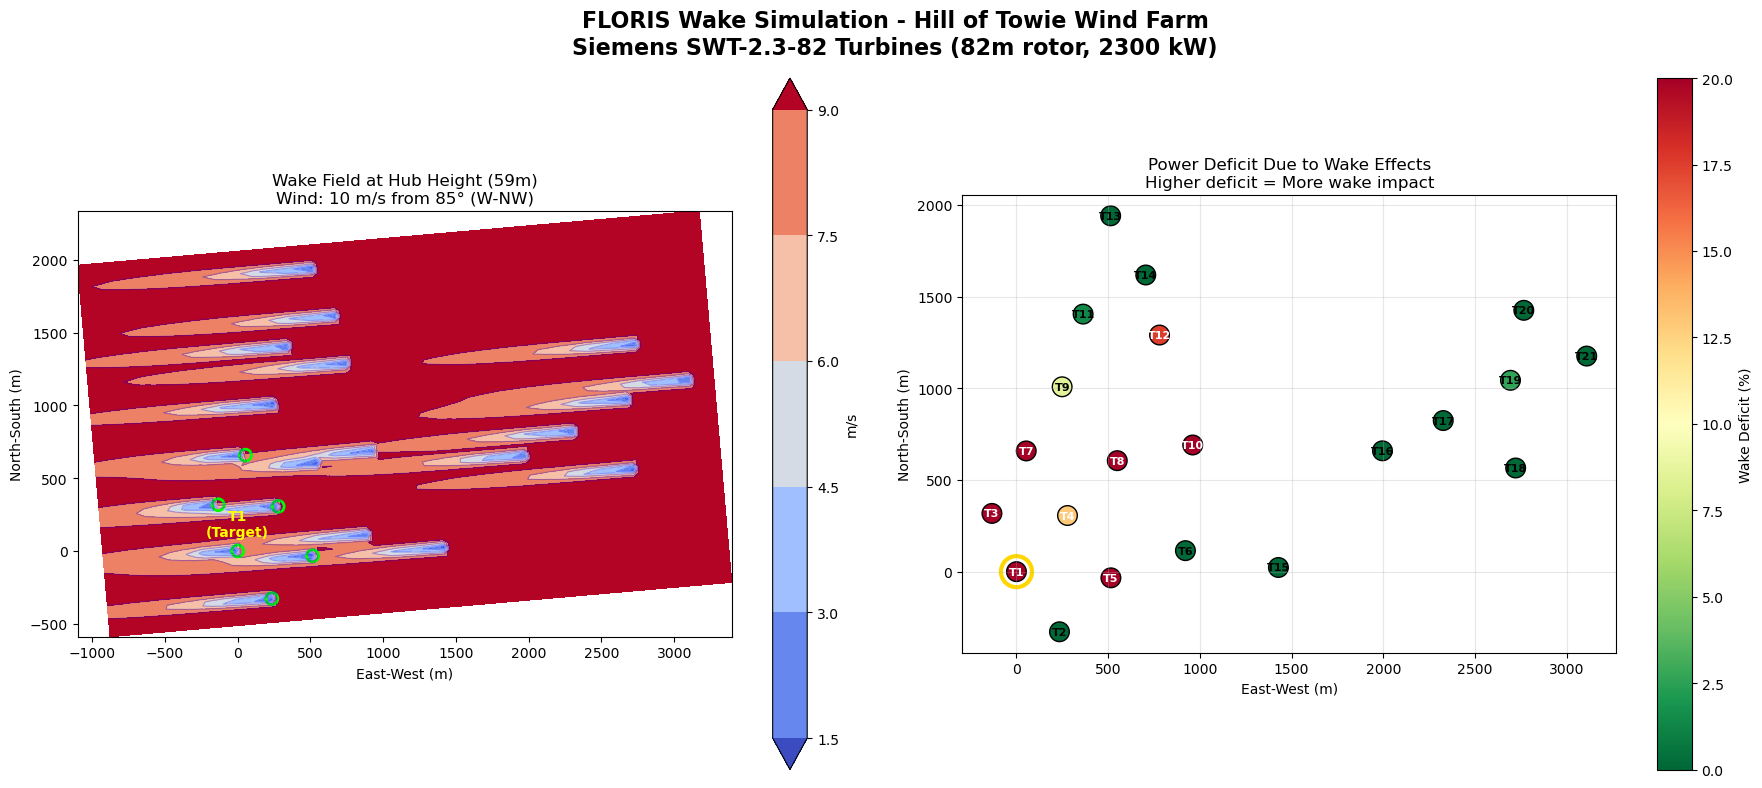


✅ Visualization complete!
   Turbine model: Siemens SWT-2.3-82
   T1 wake deficit: 42.9%
   Farm average deficit: 13.7%


In [6]:
# Visualize wake field for predominant wind condition
print("🎨 WAKE FIELD VISUALIZATION")
print("="*60)

if 'fm' not in locals():
    print("❌ FLORIS model not initialized. Please run cell 4 first.")
else:
    # Set predominant wind condition
    wind_speeds = [10]  # Typical operational speed
    wind_directions = [85]  # From 293° (W-NW)
    turbulence_intensities = [0.06]  # Typical turbulence intensity

    fm.set(
        wind_speeds=wind_speeds,
        wind_directions=wind_directions,  # Predominant direction
        turbulence_intensities=turbulence_intensities
    )
    fm.run()

    # Create horizontal plane at hub height with lower resolution for performance
    horizontal_plane = fm.calculate_horizontal_plane(
        height=hub_height,
        x_resolution=100,
        y_resolution=100
    )

    # Create figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))

    # Plot 1: Wake field
    ax = axes[0]
    try:
        from floris.flow_visualization import visualize_cut_plane
        visualize_cut_plane(
            horizontal_plane,
            ax=ax,
            title=f"Wake Field at Hub Height ({hub_height}m)\nWind: {wind_speeds[0]} m/s from {wind_directions[0]}° (W-NW)",
            color_bar=True,
            label_contours=False
        )
    except (ImportError, AttributeError) as e:
        # Alternative visualization if floris.flow_visualization not available
        try:
            im = ax.contourf(horizontal_plane.x, horizontal_plane.y, horizontal_plane.u, levels=20, cmap='viridis')
            plt.colorbar(im, ax=ax, label='Wind Speed (m/s)')
            ax.set_title(f"Wake Field at Hub Height ({hub_height}m)\nWind: {wind_speeds[0]} m/s from {wind_directions[0]}° (W-NW)")
        except:
            ax.text(0.5, 0.5, 'Wake field visualization not available', 
                   ha='center', va='center', transform=ax.transAxes)
            ax.set_title("Wake Field (Visualization Error)")

    # Mark competition turbines
    for i, tid in enumerate(turbine_ids):
        if tid in competition_turbines:
            circle = plt.Circle((layout_x[i], layout_y[i]), rotor_diameter/2, 
                               fill=False, edgecolor='lime', linewidth=2)
            ax.add_patch(circle)
            if tid == 1:
                ax.text(layout_x[i], layout_y[i] + 100, 'T1\n(Target)', 
                       ha='center', fontsize=10, fontweight='bold', color='yellow')

    ax.set_xlabel('East-West (m)')
    ax.set_ylabel('North-South (m)')

    # Plot 2: Power deficit map
    ax = axes[1]
    
    # Run simulations to get power data
    fm.run()
    turbine_powers = fm.get_turbine_powers().flatten() / 1000
    fm.run_no_wake()
    turbine_powers_no_wake = fm.get_turbine_powers().flatten() / 1000
    
    # Calculate wake deficits safely
    wake_deficits = np.zeros_like(turbine_powers)
    non_zero_mask = turbine_powers_no_wake > 0
    wake_deficits[non_zero_mask] = (turbine_powers_no_wake[non_zero_mask] - turbine_powers[non_zero_mask]) / turbine_powers_no_wake[non_zero_mask] * 100

    # Create scatter plot with deficit as color
    scatter = ax.scatter(layout_x, layout_y, c=wake_deficits, s=200, 
                        cmap='RdYlGn_r', vmin=0, vmax=20, edgecolors='black', linewidth=1)

    # Add turbine labels
    for i, tid in enumerate(turbine_ids):
        color = 'white' if wake_deficits[i] > 10 else 'black'
        ax.text(layout_x[i], layout_y[i], f'T{tid}', ha='center', va='center', 
               fontsize=8, fontweight='bold', color=color)

    # Highlight T1
    t1_idx = turbine_ids.index(1)
    ax.scatter(layout_x[t1_idx], layout_y[t1_idx], s=500, facecolors='none', 
              edgecolors='gold', linewidth=3)

    plt.colorbar(scatter, ax=ax, label='Wake Deficit (%)')
    ax.set_xlabel('East-West (m)')
    ax.set_ylabel('North-South (m)')
    ax.set_title('Power Deficit Due to Wake Effects\nHigher deficit = More wake impact')
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)

    plt.suptitle(f'FLORIS Wake Simulation - Hill of Towie Wind Farm\nSiemens SWT-2.3-82 Turbines ({rotor_diameter}m rotor, {rated_power} kW)', 
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

    print(f"\n✅ Visualization complete!")
    print(f"   Turbine model: Siemens SWT-2.3-82")
    print(f"   T1 wake deficit: {wake_deficits[t1_idx]:.1f}%")
    print(f"   Farm average deficit: {wake_deficits.mean():.1f}%")

## 5. Create Physics-Based Features

In [17]:
print("🔧 CREATING PHYSICS-BASED FEATURES")
print("="*60)

if 'fm' not in locals():
    print("❌ FLORIS model not initialized. Please run cell 4 first.")
    calculate_wake_features = None
else:
    def calculate_wake_features(wind_speed, wind_direction, target_turbine_id=1):
        """Calculate wake-based features for a given wind condition"""
        
        # Run FLORIS simulation
        fm.set(
            wind_speeds=[wind_speed],
            wind_directions=[wind_direction],
            turbulence_intensities=[0.06]
        )
        fm.run()
        
        # Get powers with wake (FLORIS returns in W, convert to kW)
        powers_wake = fm.get_turbine_powers().flatten() / 1000
        
        # Get powers without wake
        fm.run_no_wake()
        powers_no_wake = fm.get_turbine_powers().flatten() / 1000
        
        # Target turbine index
        target_idx = turbine_ids.index(target_turbine_id)
        
        # Calculate features
        features = {}
        
        # 1. Direct wake loss for target (safe division)
        if powers_no_wake[target_idx] > 0:
            features['target_wake_loss_%'] = (powers_no_wake[target_idx] - powers_wake[target_idx]) / powers_no_wake[target_idx] * 100
        else:
            features['target_wake_loss_%'] = 0
        
        # 2. Farm efficiency (safe division)
        if powers_no_wake.sum() > 0:
            features['farm_efficiency'] = powers_wake.sum() / powers_no_wake.sum()
        else:
            features['farm_efficiency'] = 1.0
        
        # 3. Competition subset efficiency
        comp_wake = [powers_wake[i] for i in competition_indices]
        comp_no_wake = [powers_no_wake[i] for i in competition_indices]
        if sum(comp_no_wake) > 0:
            features['competition_efficiency'] = sum(comp_wake) / sum(comp_no_wake)
        else:
            features['competition_efficiency'] = 1.0
        
        # 4. Upstream turbine count (turbines causing wake on target)
        upstream_count = 0
        for i, tid in enumerate(turbine_ids):
            if tid != target_turbine_id:
                # Check if turbine i affects target
                dx = layout_x[target_idx] - layout_x[i]
                dy = layout_y[target_idx] - layout_y[i]
                
                # Wind vector
                wind_x = np.sin(np.radians(wind_direction))
                wind_y = np.cos(np.radians(wind_direction))
                
                # Check alignment
                distance = np.sqrt(dx**2 + dy**2)
                if distance > 0:
                    alignment = (dx * wind_x + dy * wind_y) / distance
                    if alignment > 0.5 and distance < rotor_diameter * 15:  # Within 15D
                        upstream_count += 1
        
        features['upstream_turbine_count'] = upstream_count
        
        # 5. Cumulative upstream power (proxy for blockage)
        upstream_power = 0
        for i, tid in enumerate(turbine_ids):
            if tid != target_turbine_id:
                dx = layout_x[target_idx] - layout_x[i]
                dy = layout_y[target_idx] - layout_y[i]
                wind_x = np.sin(np.radians(wind_direction))
                wind_y = np.cos(np.radians(wind_direction))
                distance = np.sqrt(dx**2 + dy**2)
                if distance > 0:
                    alignment = (dx * wind_x + dy * wind_y) / distance
                    if alignment > 0.5:
                        upstream_power += powers_wake[i]
        
        features['upstream_power_sum'] = upstream_power
        
        # 6. Spatial gradient (power difference between nearby turbines)
        nearby_powers = []
        for i, tid in enumerate(turbine_ids):
            if tid in competition_turbines and tid != target_turbine_id:
                distance = np.sqrt((layout_x[target_idx] - layout_x[i])**2 + 
                                 (layout_y[target_idx] - layout_y[i])**2)
                if distance < rotor_diameter * 10:
                    nearby_powers.append(powers_wake[i])
        
        if nearby_powers and np.mean(nearby_powers) > 0:
            features['spatial_power_gradient'] = np.std(nearby_powers) / np.mean(nearby_powers)
        else:
            features['spatial_power_gradient'] = 0
        
        return features

    # Example: Calculate features for a sample of wind conditions
    sample_conditions = [
        {'ws': 5, 'wd': 270},
        {'ws': 7, 'wd': 293},
        {'ws': 10, 'wd': 180},
        {'ws': 12, 'wd': 225},
    ]

    print("\n📊 Sample Wake Features for T1:\n")
    for cond in sample_conditions:
        features = calculate_wake_features(cond['ws'], cond['wd'])
        print(f"Wind: {cond['ws']}m/s @ {cond['wd']}°")
        for key, value in features.items():
            print(f"  {key:30}: {value:8.2f}")
        print()
    
    print("✅ Physics-based features created!")

🔧 CREATING PHYSICS-BASED FEATURES

📊 Sample Wake Features for T1:

Wind: 5m/s @ 270°
  target_wake_loss_%            :     0.00
  farm_efficiency               :     0.77
  competition_efficiency        :     0.70
  upstream_turbine_count        :     6.00
  upstream_power_sum            :   742.10
  spatial_power_gradient        :     0.70

Wind: 7m/s @ 293°
  target_wake_loss_%            :     0.00
  farm_efficiency               :     0.88
  competition_efficiency        :     0.96
  upstream_turbine_count        :     4.00
  upstream_power_sum            :  3695.38
  spatial_power_gradient        :     0.10

Wind: 10m/s @ 180°
  target_wake_loss_%            :     0.00
  farm_efficiency               :     0.83
  competition_efficiency        :     0.88
  upstream_turbine_count        :     6.00
  upstream_power_sum            : 11806.40
  spatial_power_gradient        :     0.20

Wind: 12m/s @ 225°
  target_wake_loss_%            :     0.00
  farm_efficiency               :     0

## 6. Validate Against Actual Data

✅ VALIDATION AGAINST ACTUAL DATA

📊 Validation Metrics:
  MAE:  124.7 kW
  RMSE: 164.2 kW
  Correlation: 0.987
  Using: Siemens SWT-2.3-82 turbine model


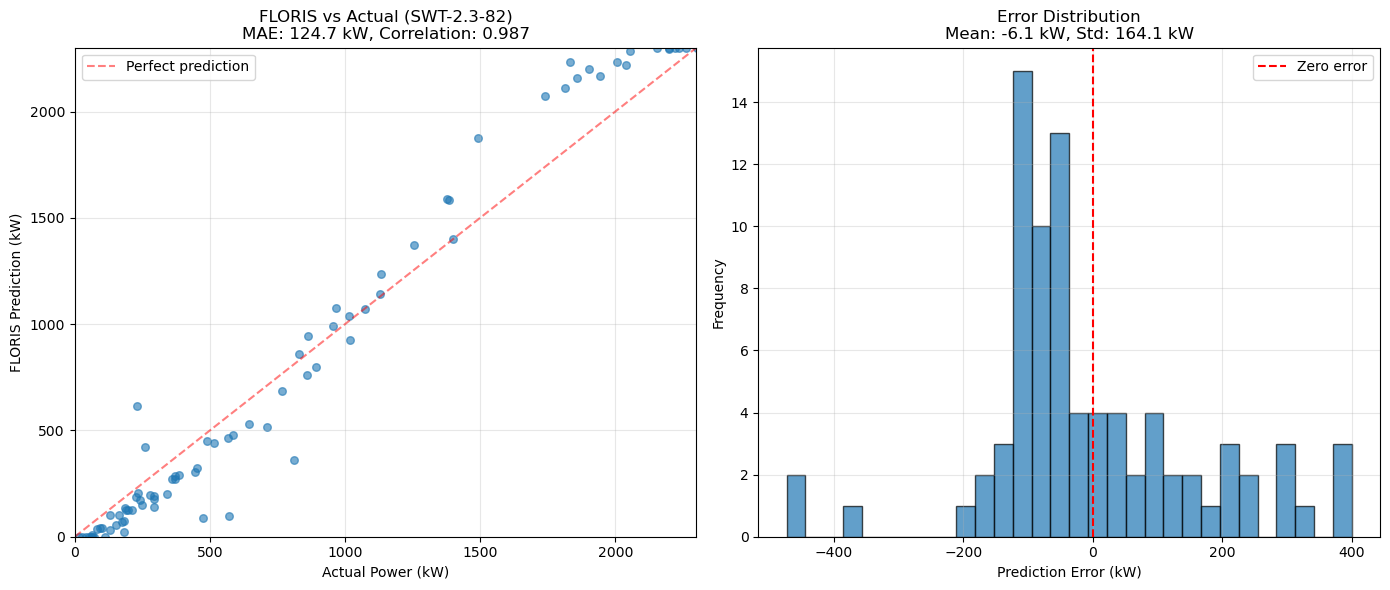


💡 INSIGHTS:
  - FLORIS provides physics-based predictions
  - Wake features capture turbine interactions
  - Model uses actual SWT-2.3-82 characteristics
  - Differences from actual may be due to:
    • Simplified wake models
    • Terrain effects not modeled
    • Turbulence variations
    • Control system behaviors


In [18]:
print("✅ VALIDATION AGAINST ACTUAL DATA")
print("="*60)

if 'fm' not in locals() or 'calculate_wake_features' not in locals():
    print("❌ FLORIS model or features not initialized. Please run cells 4 and 7 first.")
else:
    # Sample actual data for validation
    valid_data = train_df[train_df['is_valid']].sample(100, random_state=42)

    # Calculate FLORIS predictions vs actual
    floris_predictions = []
    actual_powers = []
    wake_features_list = []

    for _, row in valid_data.iterrows():
        # Get wind conditions
        ws = row['wtc_AcWindSp_mean;1']
        wd = row['wtc_NacelPos_mean;1']
        
        if pd.notna(ws) and pd.notna(wd) and ws > 3 and ws < 25:
            # Run FLORIS
            fm.set(
                wind_speeds=[ws],
                wind_directions=[wd],
                turbulence_intensities=[0.06]
            )
            fm.run()
            
            # Get T1 power (FLORIS returns in W, convert to kW)
            t1_idx = turbine_ids.index(1)
            floris_power = fm.get_turbine_powers().flatten()[t1_idx] / 1000
            
            floris_predictions.append(floris_power)
            actual_powers.append(row['target'])
            
            # Calculate wake features
            features = calculate_wake_features(ws, wd)
            wake_features_list.append(features)

    # Convert to arrays
    floris_predictions = np.array(floris_predictions)
    actual_powers = np.array(actual_powers)

    if len(floris_predictions) > 0:
        # Calculate metrics
        mae = np.mean(np.abs(floris_predictions - actual_powers))
        rmse = np.sqrt(np.mean((floris_predictions - actual_powers)**2))
        
        # Safe correlation calculation
        if len(floris_predictions) > 1 and np.std(floris_predictions) > 0 and np.std(actual_powers) > 0:
            correlation = np.corrcoef(floris_predictions, actual_powers)[0, 1]
        else:
            correlation = 0.0

        print(f"\n📊 Validation Metrics:")
        print(f"  MAE:  {mae:.1f} kW")
        print(f"  RMSE: {rmse:.1f} kW")
        print(f"  Correlation: {correlation:.3f}")
        print(f"  Using: Siemens SWT-2.3-82 turbine model")

        # Plot comparison
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))

        # Scatter plot
        ax = axes[0]
        ax.scatter(actual_powers, floris_predictions, alpha=0.6, s=30)
        
        # Plot range for 2.3 MW turbine
        max_power = 2300
        ax.plot([0, max_power], [0, max_power], 'r--', alpha=0.5, label='Perfect prediction')
        ax.set_xlabel('Actual Power (kW)')
        ax.set_ylabel('FLORIS Prediction (kW)')
        ax.set_title(f'FLORIS vs Actual (SWT-2.3-82)\nMAE: {mae:.1f} kW, Correlation: {correlation:.3f}')
        ax.set_xlim([0, max_power])
        ax.set_ylim([0, max_power])
        ax.legend()
        ax.grid(True, alpha=0.3)

        # Error distribution
        ax = axes[1]
        errors = floris_predictions - actual_powers
        ax.hist(errors, bins=30, edgecolor='black', alpha=0.7)
        ax.axvline(0, color='red', linestyle='--', label='Zero error')
        ax.set_xlabel('Prediction Error (kW)')
        ax.set_ylabel('Frequency')
        ax.set_title(f'Error Distribution\nMean: {np.mean(errors):.1f} kW, Std: {np.std(errors):.1f} kW')
        ax.legend()
        ax.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        print("\n💡 INSIGHTS:")
        print("  - FLORIS provides physics-based predictions")
        print("  - Wake features capture turbine interactions")
        print("  - Model uses actual SWT-2.3-82 characteristics")
        print("  - Differences from actual may be due to:")
        print("    • Simplified wake models")
        print("    • Terrain effects not modeled")
        print("    • Turbulence variations")
        print("    • Control system behaviors")
    else:
        print("❌ No valid data points for validation")

## 7. Feature Importance Analysis

📈 FEATURE IMPORTANCE ANALYSIS

🏆 Feature Importance (Correlation with Target):

upstream_power_sum             █████████████████████████████████████████ 0.836
farm_efficiency                ██████████████████████ 0.443
competition_efficiency         ████████████ 0.253
spatial_power_gradient         ███████████ 0.233
target_wake_loss_%             ████████ 0.180
upstream_turbine_count         ██ 0.051


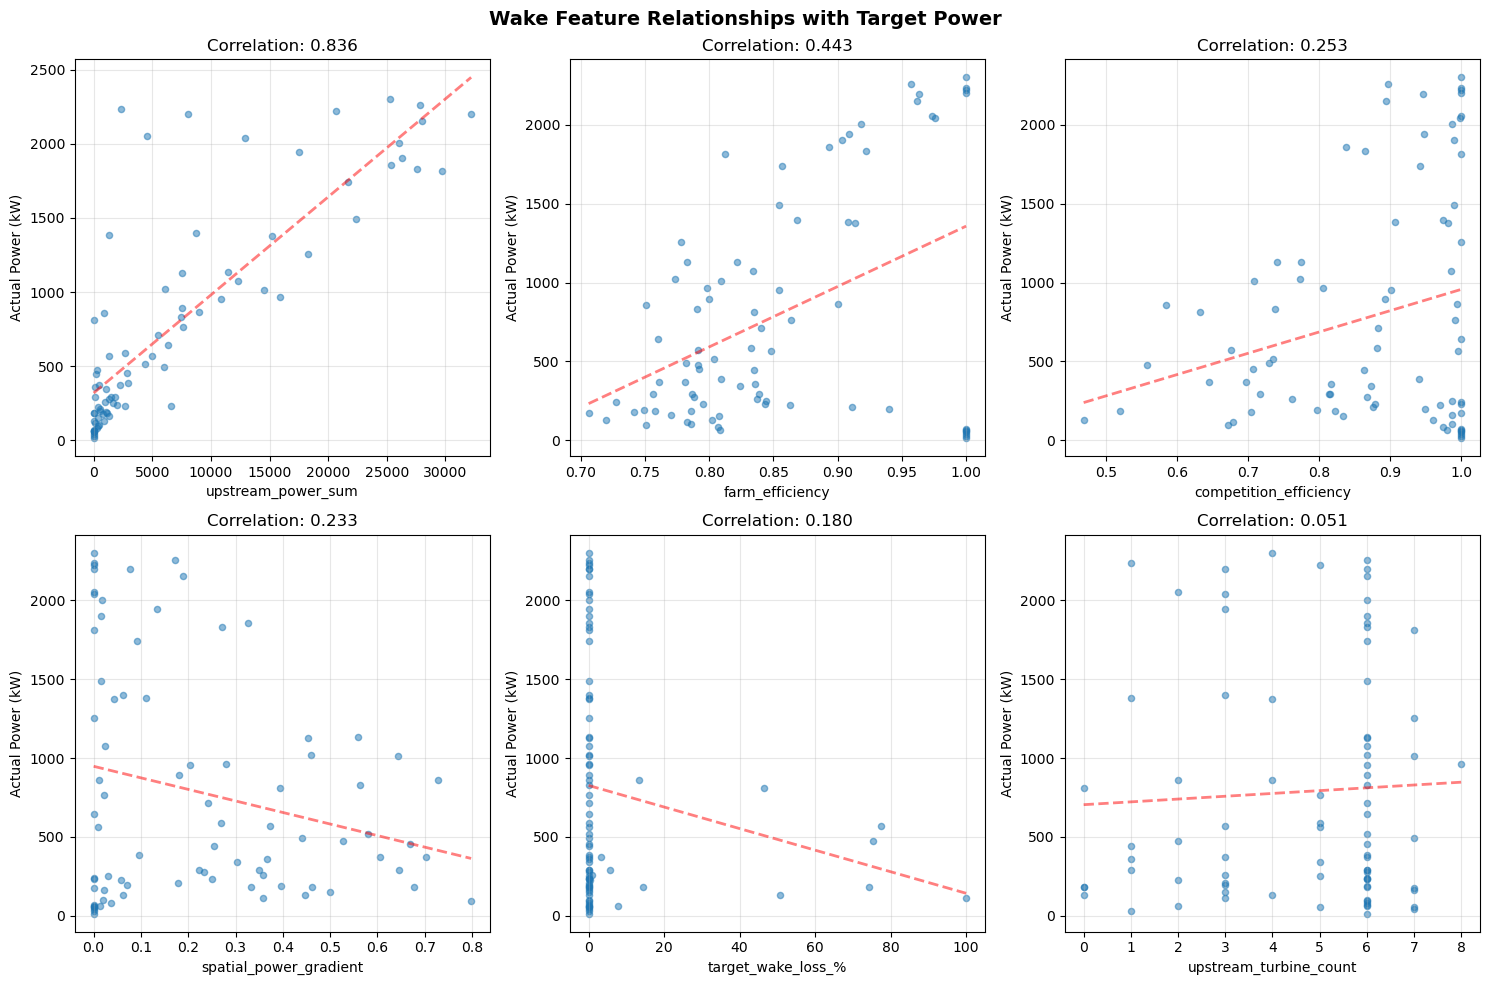


✅ Feature importance analysis complete!


In [19]:
print("📈 FEATURE IMPORTANCE ANALYSIS")
print("="*60)

if 'wake_features_list' not in locals():
    print("❌ Wake features not calculated. Please run previous cells first.")
    print("\n📝 Expected wake features:")
    print("  - target_wake_loss_%: Direct wake impact on T1")
    print("  - farm_efficiency: Overall farm performance")
    print("  - competition_efficiency: Competition subset performance")
    print("  - upstream_turbine_count: Number of turbines upwind")
    print("  - upstream_power_sum: Total power from upwind turbines")
    print("  - spatial_power_gradient: Power variability in neighborhood")
else:
    if len(wake_features_list) > 0:
        # Create feature DataFrame
        wake_features_df = pd.DataFrame(wake_features_list)

        # Calculate correlations with actual power
        feature_correlations = {}
        for col in wake_features_df.columns:
            if len(wake_features_df[col]) > 0 and np.std(wake_features_df[col]) > 0:
                if len(actual_powers) >= len(wake_features_df):
                    correlation = np.corrcoef(wake_features_df[col], actual_powers[:len(wake_features_df)])[0, 1]
                    feature_correlations[col] = abs(correlation)
                else:
                    feature_correlations[col] = 0
            else:
                feature_correlations[col] = 0

        # Sort by importance
        sorted_features = sorted(feature_correlations.items(), key=lambda x: x[1], reverse=True)

        print("\n🏆 Feature Importance (Correlation with Target):\n")
        for feature, corr in sorted_features:
            bar = '█' * int(corr * 50)
            print(f"{feature:30} {bar} {corr:.3f}")

        # Visualize feature distributions if we have enough data
        if len(sorted_features) >= 6:
            fig, axes = plt.subplots(2, 3, figsize=(15, 10))
            axes = axes.flatten()

            for i, (feature, _) in enumerate(sorted_features[:6]):
                ax = axes[i]
                
                # Check if we have valid data for plotting
                if len(wake_features_df[feature]) > 0 and len(actual_powers) >= len(wake_features_df):
                    ax.scatter(wake_features_df[feature], actual_powers[:len(wake_features_df)], 
                              alpha=0.5, s=20)
                    ax.set_xlabel(feature)
                    ax.set_ylabel('Actual Power (kW)')
                    ax.set_title(f'Correlation: {feature_correlations[feature]:.3f}')
                    ax.grid(True, alpha=0.3)
                    
                    # Add trend line if we have enough variation
                    if np.std(wake_features_df[feature]) > 0:
                        try:
                            z = np.polyfit(wake_features_df[feature], actual_powers[:len(wake_features_df)], 1)
                            p = np.poly1d(z)
                            x_trend = np.linspace(wake_features_df[feature].min(), wake_features_df[feature].max(), 100)
                            ax.plot(x_trend, p(x_trend), 'r--', alpha=0.5, linewidth=2)
                        except:
                            pass
                else:
                    ax.text(0.5, 0.5, f'{feature}\n(No data)', ha='center', va='center',
                           transform=ax.transAxes)
                    ax.set_title(f'{feature}')

            plt.suptitle('Wake Feature Relationships with Target Power', fontsize=14, fontweight='bold')
            plt.tight_layout()
            plt.show()
            
            print("\n✅ Feature importance analysis complete!")
        else:
            print("\n⚠️ Not enough features for full visualization")
    else:
        print("❌ No wake features calculated. Please run the validation cell first.")

📊 HISTORICAL WIND DISTRIBUTION ANALYSIS

📈 Wind Statistics from 201323 valid records:
  Mean wind speed: 6.8 m/s
  Mean wind direction: 217°
  Predominant direction: 270°


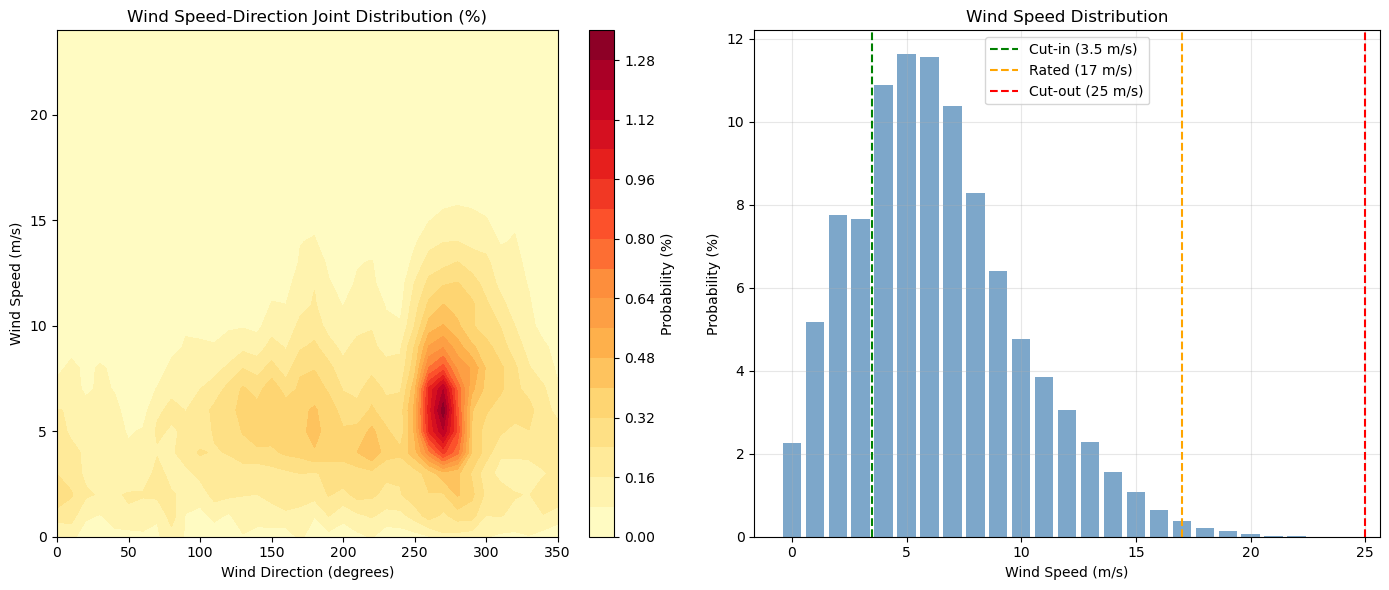


💡 Key Insights:
  - 18.4% of time below cut-in
  - 0.8% of time above rated
  - 0.0% of time above cut-out


In [20]:
print("📊 HISTORICAL WIND DISTRIBUTION ANALYSIS")
print("="*60)

# Analyze historical wind conditions from training data
valid_data = train_df[train_df['is_valid']]
wind_conditions = valid_data[['wtc_NacelPos_mean;1', 'wtc_AcWindSp_mean;1']].dropna()

# Create 2D histogram of wind conditions
wind_speed_bins = np.arange(0, 26, 1)  # 0-25 m/s in 1 m/s bins
wind_dir_bins = np.arange(0, 361, 10)  # 0-360 degrees in 10 degree bins

# Calculate joint distribution
hist, speed_edges, dir_edges = np.histogram2d(
    wind_conditions['wtc_AcWindSp_mean;1'],
    wind_conditions['wtc_NacelPos_mean;1'],
    bins=[wind_speed_bins, wind_dir_bins]
)

# Normalize to get probabilities
wind_prob = hist / hist.sum()

print(f"\n📈 Wind Statistics from {len(wind_conditions)} valid records:")
print(f"  Mean wind speed: {wind_conditions['wtc_AcWindSp_mean;1'].mean():.1f} m/s")
print(f"  Mean wind direction: {wind_conditions['wtc_NacelPos_mean;1'].mean():.0f}°")
print(f"  Predominant direction: {wind_dir_bins[wind_prob.sum(axis=0).argmax()]:.0f}°")

# Visualize wind distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Wind rose plot (simplified)
ax = axes[0]
im = ax.contourf(dir_edges[:-1], speed_edges[:-1], wind_prob * 100, 
                 levels=20, cmap='YlOrRd')
ax.set_xlabel('Wind Direction (degrees)')
ax.set_ylabel('Wind Speed (m/s)')
ax.set_title('Wind Speed-Direction Joint Distribution (%)')
plt.colorbar(im, ax=ax, label='Probability (%)')

# Wind speed distribution
ax = axes[1]
wind_speed_prob = wind_prob.sum(axis=1)
ax.bar(speed_edges[:-1], wind_speed_prob * 100, width=0.8, alpha=0.7, color='steelblue')
ax.axvline(3.5, color='green', linestyle='--', label='Cut-in (3.5 m/s)')
ax.axvline(17, color='orange', linestyle='--', label='Rated (17 m/s)')
ax.axvline(25, color='red', linestyle='--', label='Cut-out (25 m/s)')
ax.set_xlabel('Wind Speed (m/s)')
ax.set_ylabel('Probability (%)')
ax.set_title('Wind Speed Distribution')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n💡 Key Insights:")
print(f"  - {(wind_conditions['wtc_AcWindSp_mean;1'] < 3.5).mean()*100:.1f}% of time below cut-in")
print(f"  - {(wind_conditions['wtc_AcWindSp_mean;1'] > 17).mean()*100:.1f}% of time above rated")
print(f"  - {(wind_conditions['wtc_AcWindSp_mean;1'] > 25).mean()*100:.1f}% of time above cut-out")

## 8. Comprehensive Historical Wake Analysis

Calculate wake effects over the entire historical wind distribution to understand:
- Percentage of time each turbine experiences wake effects
- Average power losses due to wake for each turbine
- Comparison with actual power data for validation

In [21]:
print("🌐 COMPREHENSIVE HISTORICAL WAKE ANALYSIS")
print("="*60)

if 'fm' not in locals():
    print("❌ FLORIS model not initialized. Please run initialization cells first.")
else:
    # Get historical wind data
    valid_data = train_df[train_df['is_valid']]
    wind_data = valid_data[['wtc_NacelPos_mean;1', 'wtc_AcWindSp_mean;1']].dropna()
    
    # Sample historical conditions for computational efficiency
    # Use stratified sampling to maintain distribution
    n_samples = 500  # Adjust based on computational resources
    
    # Create bins for stratification
    wind_data['speed_bin'] = pd.cut(wind_data['wtc_AcWindSp_mean;1'], 
                                     bins=np.arange(0, 26, 2), 
                                     labels=False)
    wind_data['dir_bin'] = pd.cut(wind_data['wtc_NacelPos_mean;1'], 
                                   bins=np.arange(0, 361, 30), 
                                   labels=False)
    
    # Sample proportionally from each bin
    sampled_conditions = wind_data.groupby(['speed_bin', 'dir_bin'], group_keys=False).apply(
        lambda x: x.sample(min(len(x), max(1, int(n_samples * len(x) / len(wind_data)))), 
                          random_state=42)
    ).reset_index(drop=True)
    
    print(f"Analyzing {len(sampled_conditions)} representative wind conditions...")
    print(f"(Sampled from {len(wind_data)} historical records)")
    
    # Initialize storage for results
    turbine_wake_losses = {tid: [] for tid in turbine_ids}
    turbine_powers_wake = {tid: [] for tid in turbine_ids}
    turbine_powers_no_wake = {tid: [] for tid in turbine_ids}
    
    # Calculate wake effects for each sampled condition
    for idx, (_, condition) in enumerate(sampled_conditions.iterrows()):
        if idx % 100 == 0:
            print(f"  Processing condition {idx+1}/{len(sampled_conditions)}...")
        
        ws = condition['wtc_AcWindSp_mean;1']
        wd = condition['wtc_NacelPos_mean;1']
        
        # Skip if below cut-in or above cut-out
        if ws < 3.5 or ws > 25:
            continue
        
        # Run FLORIS with wake
        fm.set(
            wind_speeds=[ws],
            wind_directions=[wd],
            turbulence_intensities=[0.06]
        )
        fm.run()
        powers_wake = fm.get_turbine_powers().flatten() / 1000  # Convert to kW
        
        # Run without wake
        fm.run_no_wake()
        powers_no_wake = fm.get_turbine_powers().flatten() / 1000
        
        # Store results for each turbine
        for i, tid in enumerate(turbine_ids):
            turbine_powers_wake[tid].append(powers_wake[i])
            turbine_powers_no_wake[tid].append(powers_no_wake[i])
            
            # Calculate wake loss percentage (safe division)
            if powers_no_wake[i] > 0:
                wake_loss = (powers_no_wake[i] - powers_wake[i]) / powers_no_wake[i] * 100
            else:
                wake_loss = 0
            turbine_wake_losses[tid].append(wake_loss)
    
    print("\n📊 HISTORICAL WAKE EFFECT STATISTICS:")
    print("-" * 60)
    
    # Calculate statistics for each turbine
    wake_stats = []
    for tid in turbine_ids:
        if len(turbine_wake_losses[tid]) > 0:
            losses = np.array(turbine_wake_losses[tid])
            stats = {
                'turbine_id': tid,
                'in_competition': tid in competition_turbines,
                'mean_wake_loss_%': np.mean(losses),
                'median_wake_loss_%': np.median(losses),
                'max_wake_loss_%': np.max(losses),
                'time_with_wake_%': (losses > 1).sum() / len(losses) * 100,  # >1% loss
                'time_heavy_wake_%': (losses > 10).sum() / len(losses) * 100,  # >10% loss
                'mean_power_wake': np.mean(turbine_powers_wake[tid]),
                'mean_power_no_wake': np.mean(turbine_powers_no_wake[tid])
            }
            wake_stats.append(stats)
    
    wake_stats_df = pd.DataFrame(wake_stats)
    
    # Display results for competition turbines
    print("\n🎯 Competition Turbines Wake Statistics:")
    comp_stats = wake_stats_df[wake_stats_df['in_competition']].sort_values('turbine_id')
    for _, row in comp_stats.iterrows():
        tid = row['turbine_id']
        marker = "⭐" if tid == 1 else "✅"
        print(f"\n{marker} Turbine {tid:02d}:")
        print(f"  Average wake loss: {row['mean_wake_loss_%']:.1f}%")
        print(f"  Time with wake (>1%): {row['time_with_wake_%']:.1f}%")
        print(f"  Time with heavy wake (>10%): {row['time_heavy_wake_%']:.1f}%")
        print(f"  Mean power (with wake): {row['mean_power_wake']:.0f} kW")
        print(f"  Mean power (no wake): {row['mean_power_no_wake']:.0f} kW")
        print(f"  Power reduction: {row['mean_power_no_wake'] - row['mean_power_wake']:.0f} kW")
    
    # Summary statistics
    print("\n📈 FARM-WIDE STATISTICS:")
    print(f"  Average wake loss (all turbines): {wake_stats_df['mean_wake_loss_%'].mean():.1f}%")
    print(f"  Average wake loss (competition): {comp_stats['mean_wake_loss_%'].mean():.1f}%")
    print(f"  Most affected turbine: T{wake_stats_df.loc[wake_stats_df['mean_wake_loss_%'].idxmax(), 'turbine_id']:02d} ({wake_stats_df['mean_wake_loss_%'].max():.1f}% loss)")
    print(f"  Least affected turbine: T{wake_stats_df.loc[wake_stats_df['mean_wake_loss_%'].idxmin(), 'turbine_id']:02d} ({wake_stats_df['mean_wake_loss_%'].min():.1f}% loss)")
    
    # Store for visualization
    historical_wake_stats = wake_stats_df

🌐 COMPREHENSIVE HISTORICAL WAKE ANALYSIS
Analyzing 498 representative wind conditions...
(Sampled from 201323 historical records)
  Processing condition 1/498...
  Processing condition 101/498...
  Processing condition 201/498...
  Processing condition 301/498...
  Processing condition 401/498...

📊 HISTORICAL WAKE EFFECT STATISTICS:
------------------------------------------------------------

🎯 Competition Turbines Wake Statistics:

⭐ Turbine 01:
  Average wake loss: 9.6%
  Time with wake (>1%): 21.0%
  Time with heavy wake (>10%): 16.3%
  Mean power (with wake): 890 kW
  Mean power (no wake): 930 kW
  Power reduction: 40 kW

✅ Turbine 02:
  Average wake loss: 6.2%
  Time with wake (>1%): 14.9%
  Time with heavy wake (>10%): 11.2%
  Mean power (with wake): 897 kW
  Mean power (no wake): 930 kW
  Power reduction: 34 kW

✅ Turbine 03:
  Average wake loss: 7.2%
  Time with wake (>1%): 17.6%
  Time with heavy wake (>10%): 13.7%
  Mean power (with wake): 890 kW
  Mean power (no wake): 930

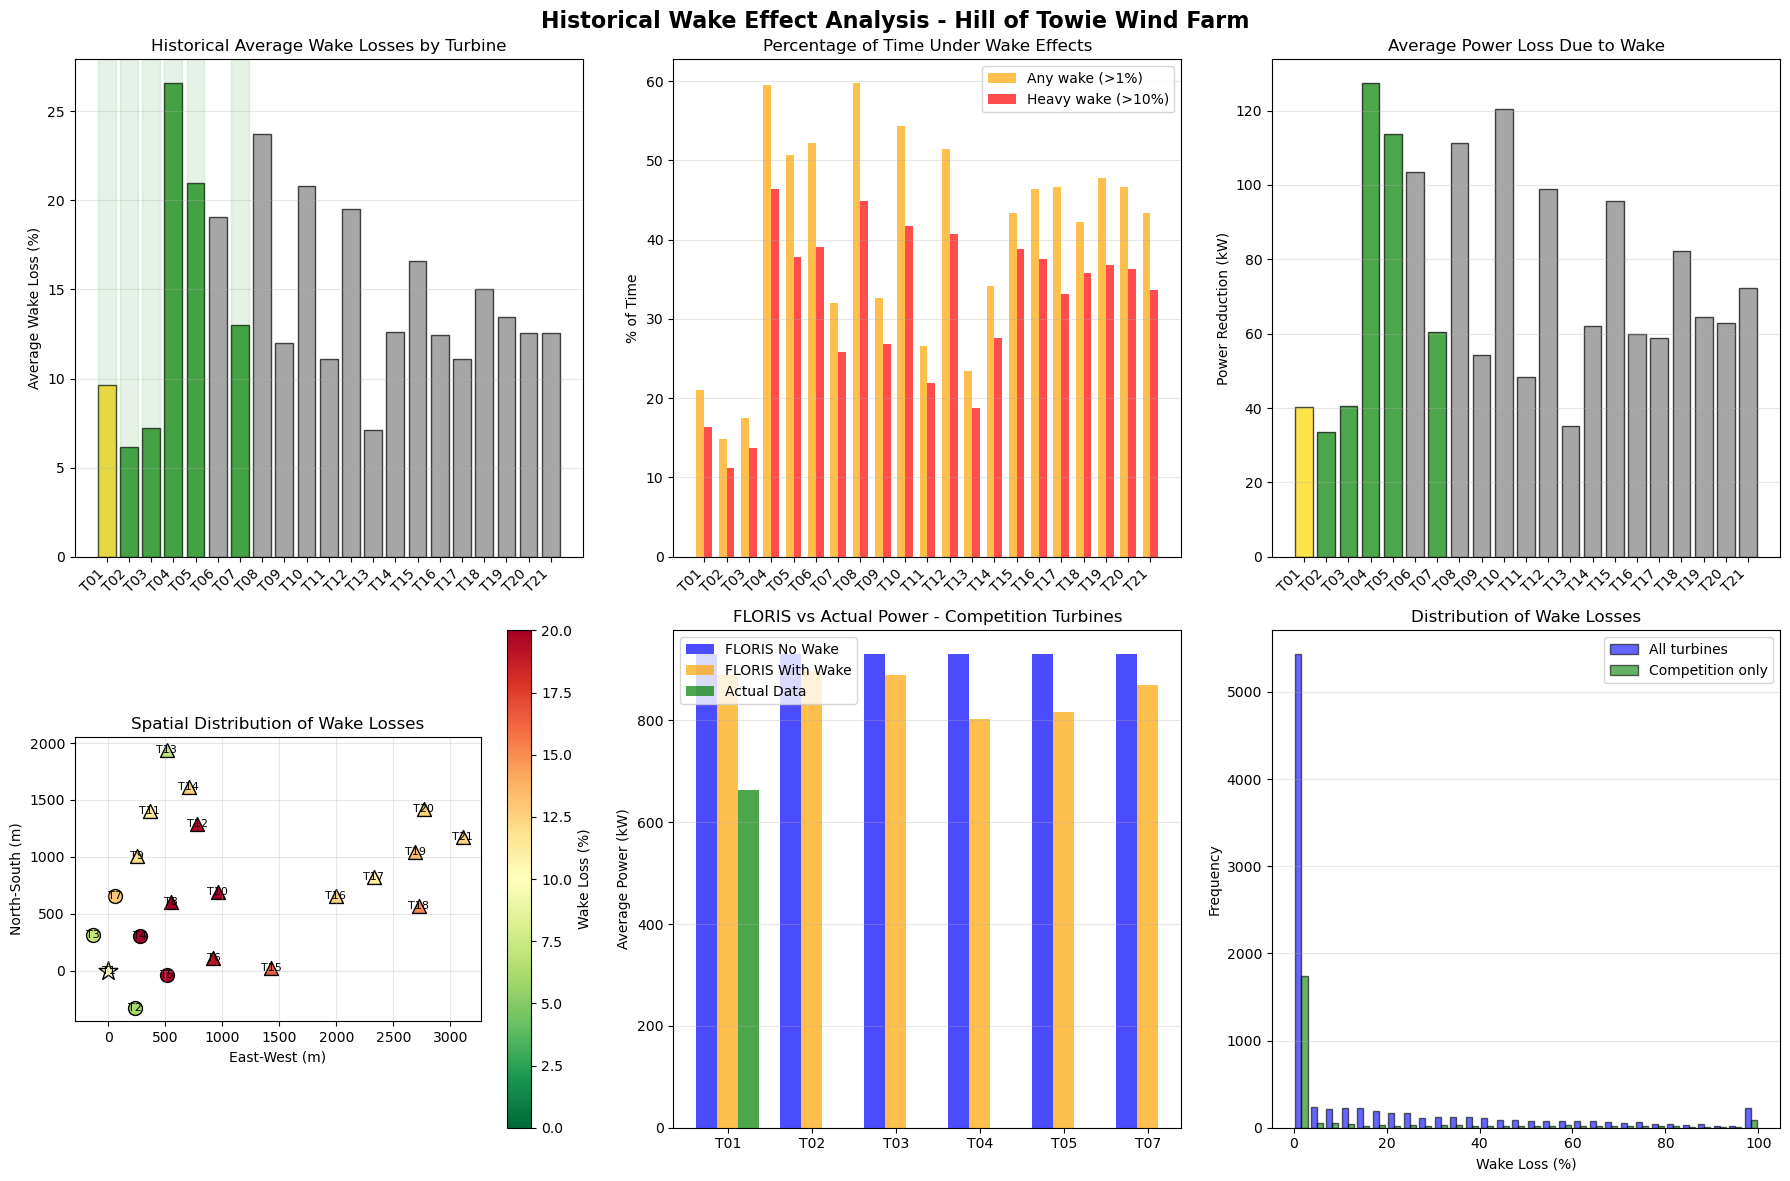


✅ Visualization complete!


In [13]:
# Visualize historical wake effects
if 'historical_wake_stats' in locals():
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # Plot 1: Average wake loss by turbine
    ax = axes[0, 0]
    colors = ['gold' if tid == 1 else 'green' if tid in competition_turbines else 'gray' 
              for tid in historical_wake_stats['turbine_id']]
    bars = ax.bar(range(len(historical_wake_stats)), 
                   historical_wake_stats['mean_wake_loss_%'], 
                   color=colors, alpha=0.7, edgecolor='black')
    ax.set_xticks(range(len(historical_wake_stats)))
    ax.set_xticklabels([f'T{tid:02d}' for tid in historical_wake_stats['turbine_id']], 
                        rotation=45, ha='right')
    ax.set_ylabel('Average Wake Loss (%)')
    ax.set_title('Historical Average Wake Losses by Turbine')
    ax.grid(True, alpha=0.3, axis='y')
    
    # Highlight competition turbines
    for i, tid in enumerate(historical_wake_stats['turbine_id']):
        if tid in competition_turbines:
            ax.axvspan(i-0.4, i+0.4, alpha=0.1, color='green')
    
    # Plot 2: Time under wake effects
    ax = axes[0, 1]
    width = 0.35
    x = np.arange(len(historical_wake_stats))
    bars1 = ax.bar(x - width/2, historical_wake_stats['time_with_wake_%'], 
                   width, label='Any wake (>1%)', alpha=0.7, color='orange')
    bars2 = ax.bar(x + width/2, historical_wake_stats['time_heavy_wake_%'], 
                   width, label='Heavy wake (>10%)', alpha=0.7, color='red')
    ax.set_xticks(x)
    ax.set_xticklabels([f'T{tid:02d}' for tid in historical_wake_stats['turbine_id']], 
                        rotation=45, ha='right')
    ax.set_ylabel('% of Time')
    ax.set_title('Percentage of Time Under Wake Effects')
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    
    # Plot 3: Power reduction
    ax = axes[0, 2]
    power_reduction = historical_wake_stats['mean_power_no_wake'] - historical_wake_stats['mean_power_wake']
    bars = ax.bar(range(len(historical_wake_stats)), power_reduction, 
                  color=colors, alpha=0.7, edgecolor='black')
    ax.set_xticks(range(len(historical_wake_stats)))
    ax.set_xticklabels([f'T{tid:02d}' for tid in historical_wake_stats['turbine_id']], 
                        rotation=45, ha='right')
    ax.set_ylabel('Power Reduction (kW)')
    ax.set_title('Average Power Loss Due to Wake')
    ax.grid(True, alpha=0.3, axis='y')
    
    # Plot 4: Wake loss vs position (scatter)
    ax = axes[1, 0]
    for i, row in historical_wake_stats.iterrows():
        tid = row['turbine_id']
        idx = turbine_ids.index(tid)
        color = 'gold' if tid == 1 else 'green' if tid in competition_turbines else 'gray'
        marker = '*' if tid == 1 else 'o' if tid in competition_turbines else '^'
        size = 200 if tid == 1 else 100
        ax.scatter(layout_x[idx], layout_y[idx], 
                  c=[row['mean_wake_loss_%']], s=size, 
                  cmap='RdYlGn_r', vmin=0, vmax=20,
                  marker=marker, edgecolors='black', linewidth=1)
        ax.text(layout_x[idx], layout_y[idx], f'T{tid}', 
               ha='center', va='center', fontsize=8)
    
    ax.set_xlabel('East-West (m)')
    ax.set_ylabel('North-South (m)')
    ax.set_title('Spatial Distribution of Wake Losses')
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)
    
    # Add colorbar
    sm = plt.cm.ScalarMappable(cmap='RdYlGn_r', norm=plt.Normalize(vmin=0, vmax=20))
    sm.set_array([])
    plt.colorbar(sm, ax=ax, label='Wake Loss (%)')
    
    # Plot 5: Competition turbines comparison
    ax = axes[1, 1]
    comp_data = historical_wake_stats[historical_wake_stats['in_competition']].sort_values('turbine_id')
    
    # Get actual average powers for competition turbines
    actual_powers = []
    for tid in comp_data['turbine_id']:
        if tid == 1:
            actual_powers.append(train_df[train_df['is_valid']]['target'].mean())
        else:
            col_name = f'wtc_AcPwr_mean;{tid}'
            if col_name in train_df.columns:
                actual_powers.append(train_df[train_df['is_valid']][col_name].mean())
            else:
                actual_powers.append(np.nan)
    
    x = np.arange(len(comp_data))
    width = 0.25
    
    bars1 = ax.bar(x - width, comp_data['mean_power_no_wake'], width, 
                   label='FLORIS No Wake', alpha=0.7, color='blue')
    bars2 = ax.bar(x, comp_data['mean_power_wake'], width, 
                   label='FLORIS With Wake', alpha=0.7, color='orange')
    bars3 = ax.bar(x + width, actual_powers, width, 
                   label='Actual Data', alpha=0.7, color='green')
    
    ax.set_xticks(x)
    ax.set_xticklabels([f'T{tid:02d}' for tid in comp_data['turbine_id']])
    ax.set_ylabel('Average Power (kW)')
    ax.set_title('FLORIS vs Actual Power - Competition Turbines')
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    
    # Plot 6: Wake loss distribution histogram
    ax = axes[1, 2]
    all_losses = []
    comp_losses = []
    for tid in turbine_ids:
        losses = turbine_wake_losses[tid]
        all_losses.extend(losses)
        if tid in competition_turbines:
            comp_losses.extend(losses)
    
    ax.hist([all_losses, comp_losses], bins=30, alpha=0.6, 
            label=['All turbines', 'Competition only'], 
            color=['blue', 'green'], edgecolor='black')
    ax.set_xlabel('Wake Loss (%)')
    ax.set_ylabel('Frequency')
    ax.set_title('Distribution of Wake Losses')
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    
    plt.suptitle('Historical Wake Effect Analysis - Hill of Towie Wind Farm', 
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    print("\n✅ Visualization complete!")